In [9]:
!pip install networkx matplotlib python-louvain

In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from networkx.algorithms.community import girvan_newman
import community  # thư viện cho Louvain
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [3]:
merged_data = pd.read_excel('merged_data.xlsx')

In [5]:
# Lọc sinh viên đã tốt nghiệp
graduated_df = merged_data[merged_data['xeploai'].notna()]

# Loại bỏ các sinh viên có mã số sinh viên trùng nhau (giữ lại bản ghi duy nhất)
graduated_df = graduated_df.drop_duplicates(subset='mssv')

# Kiểm tra số lượng sinh viên đã tốt nghiệp
print(f"Số sinh viên đã tốt nghiệp (không trùng mssv): {graduated_df.shape[0]}")


Số sinh viên đã tốt nghiệp (không trùng mssv): 1845


In [6]:
# Phân loại điểm THPT theo các nhóm đã cho
def classify_score(diem_tt):
    if diem_tt < 24.5:
        return 'Low'
    elif 24.5 <= diem_tt < 25.9:
        return 'Intermediate#1'
    elif 25.9 <= diem_tt < 29.5:
        return 'Intermediate#2'
    else:
        return 'High'

# Thêm cột phân loại điểm trúng tuyển
graduated_df['diem_tt_class'] = graduated_df['diem_tt'].apply(classify_score)

# Kiểm tra lại phân loại
print(graduated_df[['mssv', 'diem_tt', 'diem_tt_class']].head())

                                         mssv  diem_tt   diem_tt_class
0    BE375BAAXPvAibaEXe9JDlHA4z2GHJ3/PVStCxR2     31.0            High
99   2420ED57XPvAibaEXe/Lh6v1XxTKJa6JLFRUPkLM     25.5  Intermediate#1
285  91F785ABXPvAibaEXe/lOccskaOiO5y4GbVvuRQu     24.5  Intermediate#1
580  4D1054A2XPvAibaEXe8WD3qnVG2b/aV/yYzs56/D     27.0  Intermediate#2
850  C6114925XPvAibaEXe/Bn5cQSu92WepaWyZsqola     26.0  Intermediate#2


### Vẽ đồ thị 2 hướng

In [9]:
# Lọc thông tin điểm trúng tuyển và mức điểm
graduated_df['level'] = graduated_df['diem_tt'].apply(
    lambda x: 'Low' if x < 24.5 else 'Intermediate#1' if 24.5 <= x < 25.9 else 'Intermediate#2' if 25.9 <= x < 29.5 else 'High'
)

In [12]:
# Tạo đồ thị 2 hướng (giữa sinh viên và điểm trúng tuyển)
G = nx.Graph()

# Thêm đỉnh cho sinh viên và mức điểm trúng tuyển (level)
for _, row in graduated_df.iterrows():
    mssv = row['mssv']
    level = row['level']
    diem_tt = row['diem_tt']
    
    # Thêm các đỉnh sinh viên và mức điểm trúng tuyển với trọng số là điểm trúng tuyển
    G.add_node(mssv, type='student')
    G.add_node(level, type='level')
    G.add_edge(mssv, level, weight=diem_tt)  # Kết nối sinh viên với mức điểm

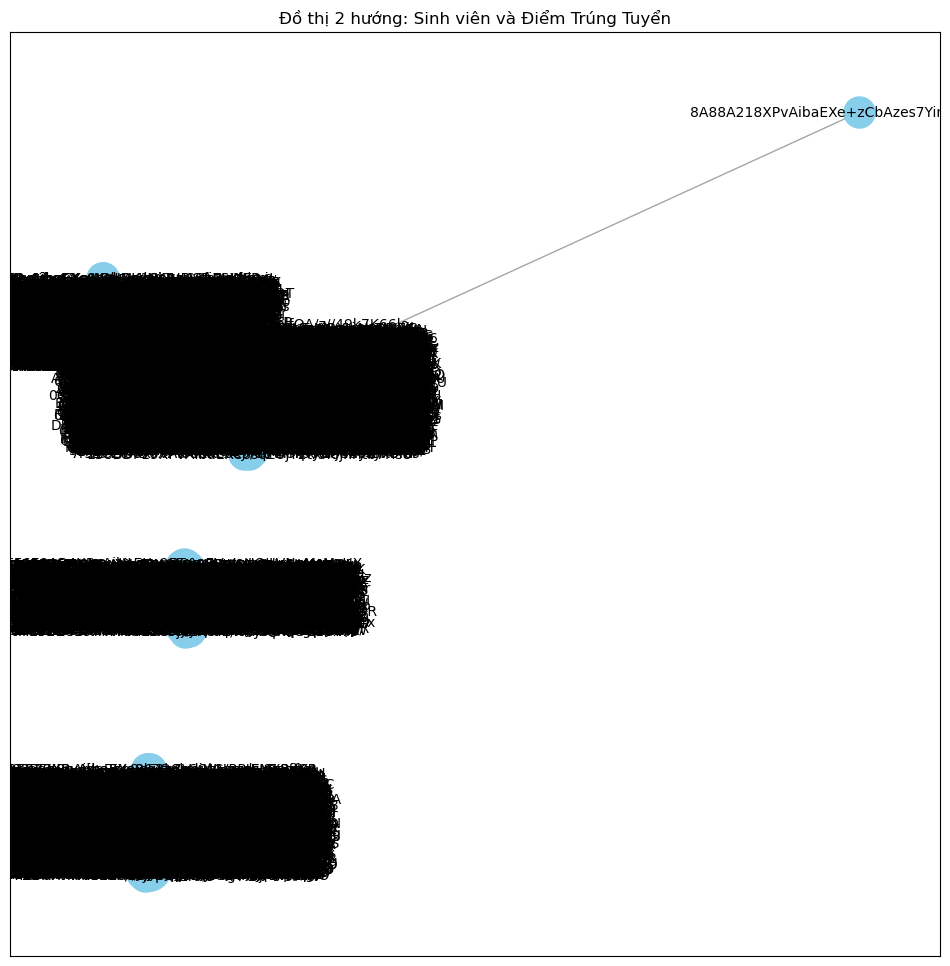

In [13]:
# Vẽ đồ thị 2 hướng
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Vị trí các đỉnh
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color='gray')
plt.title("Đồ thị 2 hướng: Sinh viên và Điểm Trúng Tuyển")
plt.show()

### Vẽ đồ thị 1 phía sinh viên

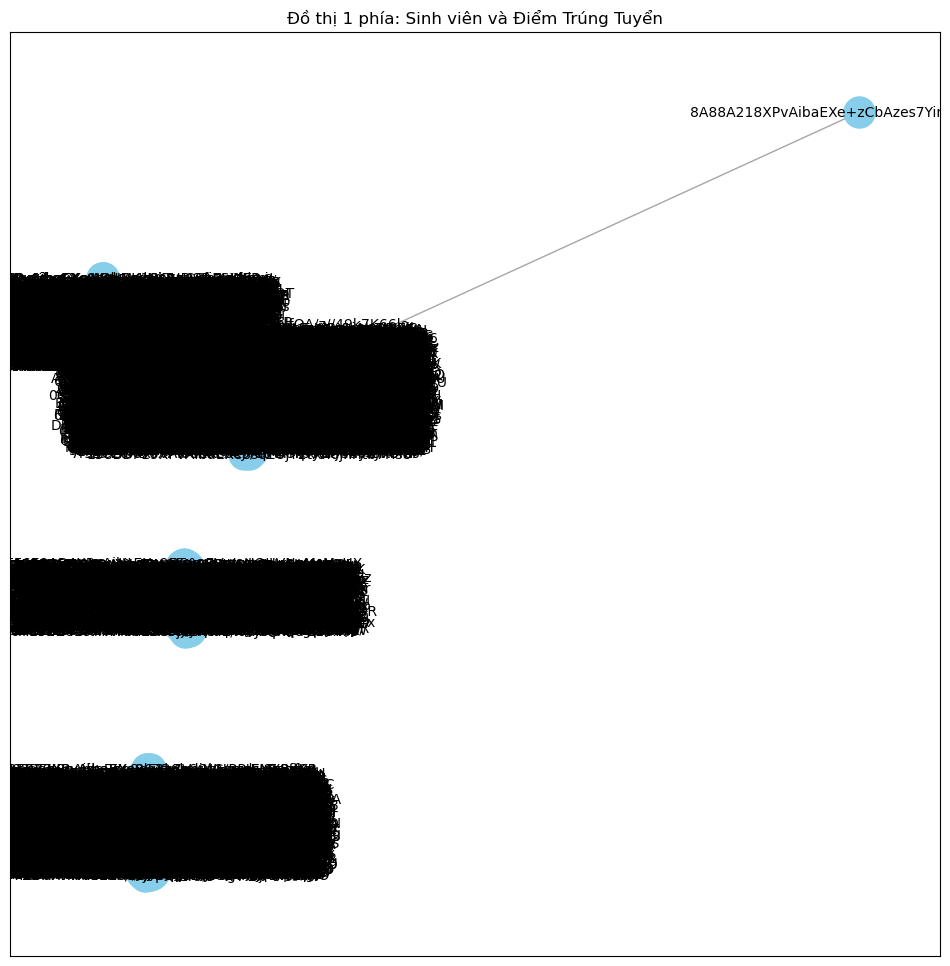

In [16]:
# Tạo đồ thị 1 phía (giữa sinh viên và điểm trúng tuyển)
G_1 = nx.Graph()

# Thêm đỉnh cho sinh viên và mức điểm trúng tuyển
for _, row in graduated_df.iterrows():
    mssv = row['mssv']
    level = row['level']
    diem_tt = row['diem_tt']
    
    # Thêm các đỉnh sinh viên và mức điểm trúng tuyển với trọng số là điểm trúng tuyển
    G_1.add_node(mssv, type='student')
    G_1.add_node(level, type='level')
    G_1.add_edge(mssv, level, weight=diem_tt)  # Kết nối sinh viên với mức điểm

# Vẽ đồ thị 1 phía
plt.figure(figsize=(12, 12))
pos_1 = nx.spring_layout(G_1, seed=42)  # Vị trí các đỉnh
nx.draw_networkx_nodes(G_1, pos_1, node_size=500, node_color='skyblue')
nx.draw_networkx_labels(G_1, pos_1, font_size=10, font_color='black')
nx.draw_networkx_edges(G_1, pos_1, width=1.0, alpha=0.7, edge_color='gray')
plt.title("Đồ thị 1 phía: Sinh viên và Điểm Trúng Tuyển")
plt.show()


### Phân tích cộng đồng

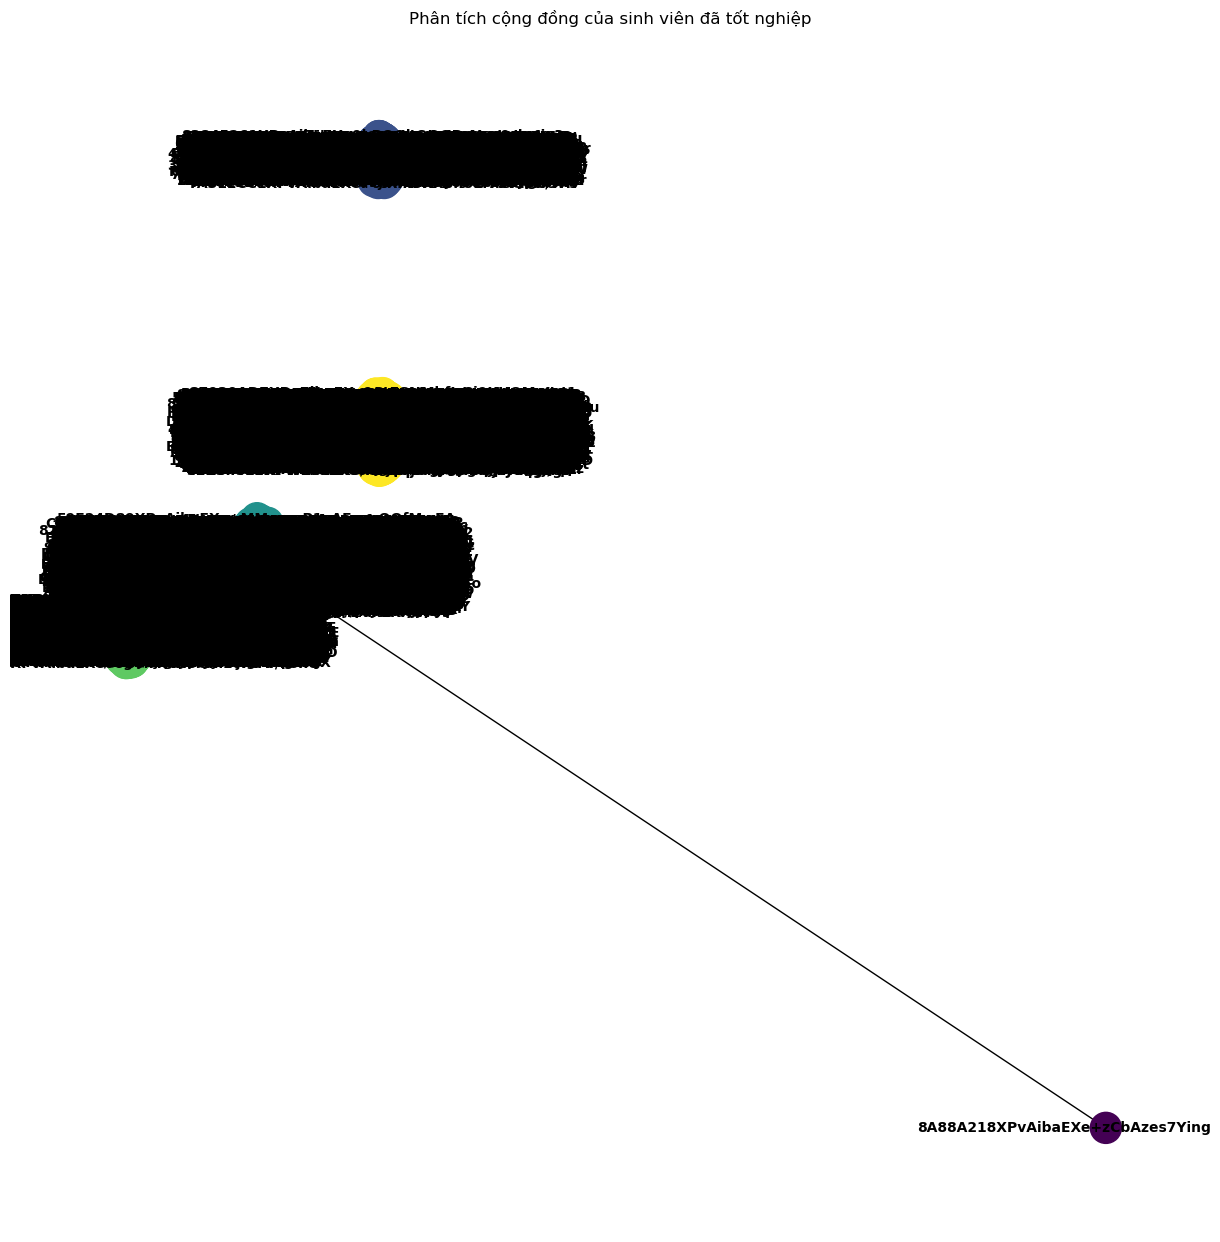

Số cộng đồng: 5


In [17]:
import community  # thư viện cho Louvain

# Phát hiện cộng đồng với thuật toán Louvain
partition = community.best_partition(G)

# Vẽ cộng đồng
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, node_color=colors, with_labels=True, node_size=500, font_size=10, font_weight='bold')
plt.title("Phân tích cộng đồng của sinh viên đã tốt nghiệp")
plt.show()

# Đếm số cộng đồng
num_communities = len(set(partition.values()))
print(f"Số cộng đồng: {num_communities}")

In [18]:
for com in set(partition.values()):
    nodes_in_community = [node for node in partition if partition[node] == com]
    print(f"Cộng đồng {com}: {nodes_in_community}")


Cộng đồng 0: ['8A88A218XPvAibaEXe+zCbAzes7Ying9a24Y8lNu']
Cộng đồng 1: ['BE375BAAXPvAibaEXe9JDlHA4z2GHJ3/PVStCxR2', 'High', '809877DCXPvAibaEXe8/3iNqySORb/0vLoIti8Og', 'FE92B059XPvAibaEXe9E+KuE/nFliSKxEUGPiMAY', '2ABBE719XPvAibaEXe9hPQQhQOOPyUJ9WJU9hlCM', '55D02CB4XPvAibaEXe9M021iVaAwIAQL8BalJRN4', 'E99E9EA2XPvAibaEXe+LLvbxzunmJFOIkyW9ng8u', 'BBAD4F2BXPvAibaEXe879+AOg1gh8vGaQYZ3wJAR', 'FC77E598XPvAibaEXe879+AOg1gh8pb/q8KzJ2A3', '85A1EF64XPvAibaEXe/asAVnWDRS7aDwG/eutYGP', 'F585674DXPvAibaEXe93PEySAJOVk6T3mUZtHkOx', '5236793DXPvAibaEXe8ge2UHv4J4B3cK3m4MI0jB', '7CAAEE6BXPvAibaEXe8ge2UHv4J4B+kFXfDUb6ad', '51E1C3E0XPvAibaEXe+4hxKfaQWuhLp2zzmiiyRe', '83845261XPvAibaEXe9hPQQhQOOPyYvq0zhwjv2w', '76CACACBXPvAibaEXe9hPQQhQOOPyV0cvrwNuPGz', '302C659FXPvAibaEXe80gGmWuNekT9HQE57P7S6C', '740BF475XPvAibaEXe80gGmWuNekT0DMGoGib8Ko', '314A9EFDXPvAibaEXe83EtiN4MI2ntxuuYLz7OKp', '6F75613CXPvAibaEXe8/3iNqySORbxrmFjIeDct7', '1D719539XPvAibaEXe8/3iNqySORb0aV1QVzGOA5', '45213E72XPvAibaEXe/lOccskaOiO/d9phcRuPc

In [21]:
# Tạo DataFrame với nhãn cộng đồng
graduated_df['community'] = graduated_df['mssv'].map(partition)

# Kiểm tra dữ liệu
print(graduated_df[['mssv', 'diem_tt', 'community']].head())

                                         mssv  diem_tt  community
0    BE375BAAXPvAibaEXe9JDlHA4z2GHJ3/PVStCxR2     31.0          1
99   2420ED57XPvAibaEXe/Lh6v1XxTKJa6JLFRUPkLM     25.5          3
285  91F785ABXPvAibaEXe/lOccskaOiO5y4GbVvuRQu     24.5          3
580  4D1054A2XPvAibaEXe8WD3qnVG2b/aV/yYzs56/D     27.0          4
850  C6114925XPvAibaEXe/Bn5cQSu92WepaWyZsqola     26.0          4


In [25]:
# Lựa chọn các đặc trưng đầu vào và nhãn
X = graduated_df[['diem_tt', 'dtbhk']]
y = graduated_df['community']  # Nhãn là cộng đồng

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Tạo và huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Dự đoán trên tập kiểm tra
y_pred = rf_model.predict(X_test)

In [28]:
# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy}")
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Độ chính xác của mô hình: 0.997289972899729
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00        50
           2       0.99      1.00      1.00       148
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00       113

    accuracy                           1.00       369
   macro avg       0.80      0.80      0.80       369
weighted avg       0.99      1.00      1.00       369



D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
results = X_test.copy()
results['true_community'] = y_test
results['predicted_community'] = y_pred
print(results.head())

        diem_tt  dtbhk  true_community  predicted_community
291018    23.25   6.39               2                    2
201831    20.75   7.99               2                    2
131211    25.00   6.96               3                    3
276436    23.75   5.78               2                    2
232370    23.00   8.86               2                    2


In [30]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/124.9 MB 2.6 MB/s eta 0:00:49
   ---------------------------------------- 1.3/124.9 MB 2.2 MB/s eta 0:00:58
    --------------------------------------- 1.6/124.9 MB 2.0 MB/s eta 0:01:02
    --------------------------------------- 1.8/124.9 MB 2.0 MB/s eta 0:01:02
    --------------------------------------- 2.4/124.9 MB 1.9 MB/s eta 0:01:03
    --------------------------------------- 2.9/124.9 MB 2.0 MB/s eta 0:01:02
   - -------------------------------------- 3.1/124.9 MB 2.0 MB/s eta 0:01:02
   - -------------------------------------- 3.4/124.9 MB 1.9 MB/s eta 0:01:03
   - -------------------------------------- 3.7/124.9 MB 1.8 MB/s eta 0:01:07
   - -------------------------------------- 4.2/124.9 MB 1.8 MB/s eta 0:01:07
   - -------------------------------------- 4.5/124.9 MB 1.8 MB/s eta 0:01:06


In [34]:
from sklearn.neighbors import KNeighborsClassifier

# Tạo và huấn luyện KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_knn = knn_model.predict(X_test)

# Đánh giá mô hình
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Độ chính xác của KNN: {accuracy_knn}")
print("Báo cáo phân loại cho KNN:")
print(classification_report(y_test, y_pred_knn))

Độ chính xác của KNN: 0.994579945799458
Báo cáo phân loại cho KNN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00        50
           2       0.99      0.99      0.99       148
           3       0.98      1.00      0.99        57
           4       1.00      1.00      1.00       113

    accuracy                           0.99       369
   macro avg       0.80      0.80      0.80       369
weighted avg       0.99      0.99      0.99       369



D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
from sklearn.svm import SVC

# Tạo và huấn luyện SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_svm = svm_model.predict(X_test)

# Đánh giá mô hình
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Độ chính xác của SVM: {accuracy_svm}")
print("Báo cáo phân loại cho SVM:")
print(classification_report(y_test, y_pred_svm))

Độ chính xác của SVM: 0.991869918699187
Báo cáo phân loại cho SVM:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00        50
           2       0.99      1.00      1.00       148
           3       1.00      0.96      0.98        57
           4       0.98      1.00      0.99       113

    accuracy                           0.99       369
   macro avg       0.80      0.79      0.79       369
weighted avg       0.99      0.99      0.99       369



D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Tạo và huấn luyện Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_logreg = logreg_model.predict(X_test)

# Đánh giá mô hình
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Độ chính xác của Logistic Regression: {accuracy_logreg}")
print("Báo cáo phân loại cho Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))


Độ chính xác của Logistic Regression: 0.997289972899729
Báo cáo phân loại cho Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00        50
           2       0.99      1.00      1.00       148
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00       113

    accuracy                           1.00       369
   macro avg       0.80      0.80      0.80       369
weighted avg       0.99      1.00      1.00       369



D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Ancacoda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
# So sánh hiệu năng các mô hình
print(f"Logistic Regression Accuracy: {accuracy_logreg}")
print(f"SVM Accuracy: {accuracy_svm}")
print(f"KNN Accuracy: {accuracy_knn}")

Logistic Regression Accuracy: 0.997289972899729
SVM Accuracy: 0.991869918699187
KNN Accuracy: 0.994579945799458
